# Version 0.0.1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import datetime as dt
import pandas as pd
from skimage import io
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# Settings:
NUM_EPOCHS = 15
BATCH_SIZE = 10
DIM = 100
NUM_WORKERS = 0
googleFolderPath = "C:\\food-training-images-database\\data\\food images\\google"

# Data Preparation

To prepare for learning we first select the most recent subfolder from the google folder which coresponds to the most recent run of the image scraper tool so make sure the google folder contains at least one subfolder with image data in it. Next, the train and test images are loaded for each class.

In [2]:
if not os.path.exists(googleFolderPath):
    raise ValueError('The specified google folder path does not exist.')
    
# Get the subfolders of the google folder
subfolders = [name for name in os.listdir(googleFolderPath) if os.path.isdir(os.path.join(googleFolderPath, name))]
subfoldersDates = []
for i in range(0, len(subfolders)):
    subfoldersDates.append(dt.datetime.strptime(subfolders[i], "%d%m%y_%H%M"))
    
if len(subfolders) <= 0 or len(subfoldersDates) <= 0:
    raise ValueError('No image data found, run the image scaper tool.')

# Sort the subfolders by date and select the most recent
subfoldersDates.sort()
databasePath = googleFolderPath + "\\" + subfoldersDates[-1].strftime("%d%m%y_%H%M") + "\\DL"
trainSetCSV = pd.read_csv(databasePath + "\\train_clean.csv")
testSetCSV = pd.read_csv(databasePath + "\\test_clean.csv")
trainSetPath = databasePath + "\\training_images"
testSetPath = databasePath + "\\testing_images"
loadErrors_train = 0
loadErrors_test = 0

# Read the different classnames from the train.csv file
classnames = []
for label in trainSetCSV.iloc[:, 2]:
    if label not in classnames:
        classnames.append(label)

# Load training images as PIL images
train_images_paths = []
train_images = []
train_classLabels = []
for i, imgPath in enumerate(trainSetCSV.iloc[:, 4]):
    try: # If this fails it means that the path specified in the csv file os not correct or the image is in a wrong format
        img = Image.open(trainSetPath + "\\" + str(imgPath))
        if img.size != (DIM, DIM):
            raise ValueError('Image is wrong size: ({0}, {1}) should be ({2}, {3})'.format(img.size[0], img.size[1], DIM, DIM))
        train_images.append(img)
        train_images_paths.append(trainSetPath + "\\" + str(imgPath))
        train_classLabels.append(trainSetCSV.iloc[i, 1])
    except:
        loadErrors_train += 1
#     
# Load testing images as PIL images
test_images_paths = []
test_images = []
test_classLabels = []
for i, imgPath in enumerate(testSetCSV.iloc[:, 4]):
    try: # If this fails it means that the path specified in the csv file os not correct or the image is in a wrong format
        test_images.append(Image.open(testSetPath + "\\" + str(imgPath)))
        test_images_paths.append(testSetPath + "\\" + str(imgPath))
        test_classLabels.append(testSetCSV.iloc[i, 1])
    except:
        loadErrors_test += 1
        
# Print data summary
print("Data summary:\n\nTraining data path: {0}\nTesting data path: {1}\nNumber of classes: {2}\nClass names: {3}\nUseable training images in total: {4}\nUseable test images in total: {5}\nTraining data errors: {6}\nTesting data errors: {7}".format(
        trainSetPath,
        testSetPath,
        len(classnames), 
        classnames, 
        len(train_images),
        len(test_images),
        loadErrors_train,
        loadErrors_test))

# Check for errors and warnings
if len(train_images) < 1:
    raise ValueError("\nFailed to load any training images.")

if len(test_images) < 1:
    raise ValueError("\nFailed to load any testing images.")

if loadErrors_train > 0:
    print("\nWARNING: There seems to be {0} cases where a path from the train.csv file did not point to a readable image in the training_images folder. This is likely do to bugs in the scraper tool. Make sure all paths in the CSV files points to a readable image of size ({1}, {2}) or ignore the errors and continue with only {3} training images.".format(loadErrors_train, DIM, DIM, len(train_images)))
else:
    print("\nSuccesfully loaded training images with no errors via train.csv.")

if loadErrors_test > 0:
    print("\nWARNING: There seems to be {0} cases where a path from the test.csv file did not point to a readable image in the testing_images folder. This is likely do to bugs in the scraper tool. Make sure all paths in the CSV files points to a readable image of size ({1}, {2}) or ignore the errors and continue with only {3} testing images.".format(loadErrors_test, DIM, DIM, len(test_images)))
else:
    print("\nSuccesfully loaded testing images with no errors via test.csv.") 
    


Data summary:

Training data path: C:\food-training-images-database\data\food images\google\291018_1724\DL\training_images
Testing data path: C:\food-training-images-database\data\food images\google\291018_1724\DL\testing_images
Number of classes: 5
Class names: ['Milk', 'Egg', 'Bread', 'Cheese', 'Meat']
Useable training images in total: 1027
Useable test images in total: 112
Training data errors: 28
Testing data errors: 3




An efficient data generation scheme is crucial to leverage the full potential of your CPU (or GPU) during the training process so that the data generation process does not become a bottleneck. When the training and testing images has been loaded in the above, we can set up the dataloaders. For data loading, we implement a class that inherits the highly optimized Dataset type, and defines the data reading functions and data access functions as well as transforms that we will like to apply.

In [3]:
class FoodDataset(torch.utils.data.Dataset):
    
    def __init__(self, datasetType, transform):
        
        if datasetType == "Training":
            self.images = train_images
            self.labels = train_classLabels
        elif datasetType == "Testing":
            self.images = test_images
            self.labels = test_classLabels
        else:
            raise ValueError("datasetType should be either 'Training' or 'Testing'.")
            
        self.transform = transform;
        
    def __len__(self):
        return len(self.images);
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        label = self.labels[idx]
        
        return {"image": image, "label": label};
    
# CUDA for PyTorch
use_cuda = torch.cuda.is_available() and False
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Using device: {0}".format(device))

# Parameters
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': NUM_WORKERS}
max_epochs = NUM_EPOCHS 

# Transformation
#transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform=transforms.Compose([transforms.ToTensor()])

# Data sets and loaders
training_set = FoodDataset(datasetType="Training", transform=transform)
training_dataloader = torch.utils.data.DataLoader(training_set, **params)

test_set = FoodDataset(datasetType="Testing", transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_set, **params)


Using device: cpu


We can now easely get a single sample by index or use the dataloaders for batch training. A sample will consist of two objects: an image and a label like so:

The image looks like this when shown:


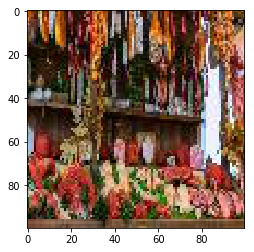

Its class label is '4' which is 'Meat'


In [4]:
# Get the last sample from the training set dataloader
sample = training_set[-1]
sample_image = sample["image"]
sample_label = sample["label"]
sample_label_name = classnames[sample_label]

# Plot the image and print its class label and the name of its class label
# When plotting an image we always swap the axis so that the image is displayed correctly
print("The image looks like this when shown:")
sample_image = sample_image.transpose(0, 2) # Swap axis 0 and 2
sample_image = sample_image.transpose(0, 1) # Swap axis 0 and 1
plt.imshow(sample_image)
plt.show()
print("Its class label is '{0}' which is '{1}'".format(sample_label, sample_label_name))

Let's print out a few images from each class to make sure everything is correctly set up and that the correct class names are associated with the correct images.

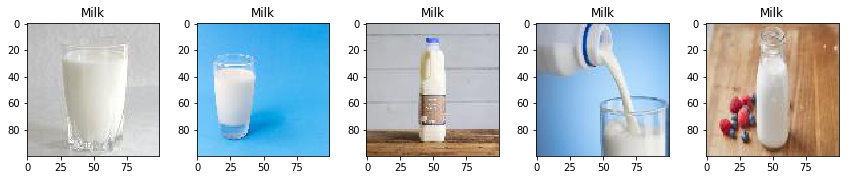

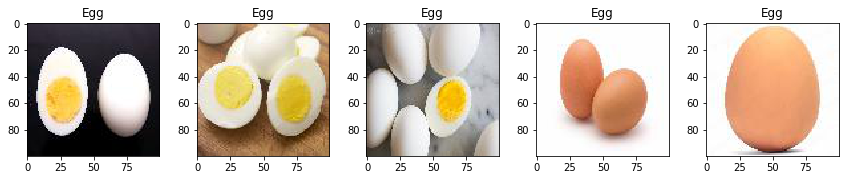

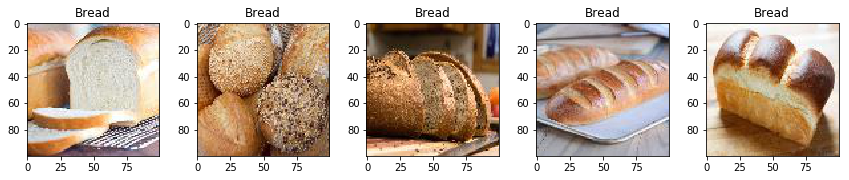

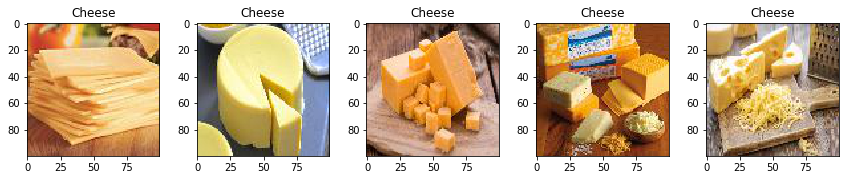

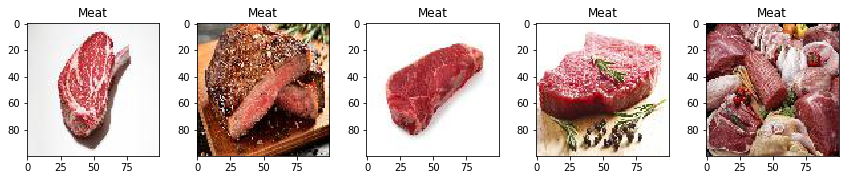

In [5]:
numberOfImagesToShowPerClass = 5
showAxis = True

for i in range(0, len(classnames)):
    k = 0
    plt.figure(figsize=(12,12))
    for j in range(0, len(training_set)):
        if training_set[j]["label"] == i and k < numberOfImagesToShowPerClass:
            imgSample = training_set[j]["image"]
            imgSample = imgSample.transpose(0, 2) # Swap axis 0 and 2
            imgSample = imgSample.transpose(0, 1) # Swap axis 0 and 1
            ax = plt.subplot(len(classnames), numberOfImagesToShowPerClass, k+1)
            plt.tight_layout()
            ax.set_title("{0}".format(classnames[i]))
            if not showAxis:
                ax.axis('off')
            plt.imshow(imgSample)
            k += 1

plt.show()

# Define a Neural Network

We define a neural network.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, Conv3d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, max_pool2d

# hyperameters of the model
channels = training_set[0]["image"].shape[0]
height = training_set[0]["image"].shape[1]
width = training_set[0]["image"].shape[2]
print("Channels = {0}\nHeight = {1}\nWidth = {2}".format(channels, height, width))

num_filters_conv1 = 16
kernel_size_conv1 = 4 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 0

num_filters_conv2 = 32
kernel_size_conv2 = 4 # [height, width]
stride_conv2 = 2 # [stride_height, stride_width]
padding_conv2 = 0

num_filters_conv3 = 64
kernel_size_conv3 = 4 # [height, width]
stride_conv3 = 2 # [stride_height, stride_width]
padding_conv3 = 0

num_l1 = 500
num_l2 = 250

def compute_conv_dim(dim_size, kernel_size, padding, stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        # First 2D convolutional layer
        self.conv_1 = Conv2d(in_channels=channels, 
                             out_channels=num_filters_conv1, 
                             kernel_size=kernel_size_conv1, 
                             stride=stride_conv1)
        self.conv1_out_height = compute_conv_dim(height, kernel_size_conv1, padding_conv1, stride_conv1)
        self.conv1_out_width = compute_conv_dim(width, kernel_size_conv1, padding_conv1, stride_conv1)
        #self.zeroPad_conv1 = nn.ZeroPad2d(padding_conv1)
        
        # Second 2D convolutional layer
        self.conv_2 = Conv2d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2, 
                             kernel_size=kernel_size_conv2, 
                             stride=stride_conv2)
        self.conv2_out_height = compute_conv_dim(self.conv1_out_height, kernel_size_conv2, padding_conv2, stride_conv2)
        self.conv2_out_width = compute_conv_dim(self.conv1_out_width, kernel_size_conv2, padding_conv2, stride_conv2)
        #self.zeroPad_conv2 = nn.ZeroPad2d(padding_conv2)
        
        # Third 2D convolutional layer
        self.conv_3 = Conv2d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv3, 
                             kernel_size=kernel_size_conv3, 
                             stride=stride_conv3)
        self.conv3_out_height = compute_conv_dim(self.conv2_out_height, kernel_size_conv3, padding_conv3, stride_conv3)
        self.conv3_out_width = compute_conv_dim(self.conv2_out_width, kernel_size_conv3, padding_conv3, stride_conv3)
        #self.zeroPad_conv2 = nn.ZeroPad2d(padding_conv2)
        
        self.l1_in_features = 28224
        
        self.l_1 = Linear(in_features=self.l1_in_features, out_features=num_l1, bias=True)
        self.l_2 = Linear(in_features=num_l1, out_features=num_l2, bias=True)
        self.l_out = Linear(in_features=num_l2, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.conv_1(x)
        x = relu(x)
        x = max_pool2d(x, kernel_size=2, padding=0, stride=1)
        
        x = self.conv_2(x)
        x = relu(x)
        x = max_pool2d(x, kernel_size=2, padding=0, stride=1)
        
        x = self.conv_3(x)
        x = relu(x)
        x = max_pool2d(x, kernel_size=2, padding=0, stride=1)

        x = x.view(x.size(0),-1)
        
        x = relu(self.l_1(x))
        x = relu(self.l_2(x))
        x = self.l_out(x)
        #x = softmax(x, dim=1)
        return x
    

net = Net(len(classnames))
if use_cuda:
    print('##converting network to cuda-enabled')
    net.cuda()
print(net)

Channels = 3
Height = 100
Width = 100
Net(
  (conv_1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (conv_3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (l_1): Linear(in_features=28224, out_features=500, bias=True)
  (l_2): Linear(in_features=500, out_features=250, bias=True)
  (l_out): Linear(in_features=250, out_features=5, bias=True)
)


# Define Loss Function and Optimizer

We define a loss function and an optimizer

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Train the Network

Now we train the network

In [8]:
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

print('Training. Please wait...')

for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(training_dataloader):
        # get the inputs
        #print(data)
        inputs, labels = data["image"], data["label"]

        # wrap them in Variable
        if use_cuda:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    
        # print statistics
        running_loss += loss.data[0]
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

Training. Please wait...


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,    10] loss: 0.016
[1,    20] loss: 0.016
[1,    30] loss: 0.016
[1,    40] loss: 0.016
[1,    50] loss: 0.014
[1,    60] loss: 0.014
[1,    70] loss: 0.014
[1,    80] loss: 0.013
[1,    90] loss: 0.012
[1,   100] loss: 0.013
[2,    10] loss: 0.013
[2,    20] loss: 0.012
[2,    30] loss: 0.012
[2,    40] loss: 0.012
[2,    50] loss: 0.011
[2,    60] loss: 0.011
[2,    70] loss: 0.012
[2,    80] loss: 0.012
[2,    90] loss: 0.012
[2,   100] loss: 0.010
[3,    10] loss: 0.010
[3,    20] loss: 0.010
[3,    30] loss: 0.010
[3,    40] loss: 0.009
[3,    50] loss: 0.010
[3,    60] loss: 0.011
[3,    70] loss: 0.010
[3,    80] loss: 0.009
[3,    90] loss: 0.010
[3,   100] loss: 0.012
[4,    10] loss: 0.011
[4,    20] loss: 0.009
[4,    30] loss: 0.010
[4,    40] loss: 0.010
[4,    50] loss: 0.008
[4,    60] loss: 0.009
[4,    70] loss: 0.010
[4,    80] loss: 0.008
[4,    90] loss: 0.010
[4,   100] loss: 0.009
[5,    10] loss: 0.010
[5,    20] loss: 0.009
[5,    30] loss: 0.008
[5,    40] 

# Test the Network

In [9]:
correct = 0
total = 0

for data in test_dataloader:
    images, labels = data["image"], data["label"]
    if use_cuda:
        outputs = net(Variable(images.cuda()))
    else:
        outputs = net(Variable(images))
        
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    if use_cuda:
        correct += (predicted == labels.cuda()).sum()
    else:
        correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    len(test_set), 100 * correct / total))

print("(Random guessing would be {:4.2f} % on average)\n".format(100/len(classnames)))
    
class_total = list(0. for i in range(len(classnames)))
class_correct = list(0. for i in range(len(classnames)))

for data in test_dataloader:
    images, labels = data["image"], data["label"]
    if use_cuda:
        outputs = net(Variable(images.cuda()))
    else:
        outputs = net(Variable(images))
        
    _, predicted = torch.max(outputs.data, 1)
    
    if use_cuda:
        c = (predicted == labels.cuda()).squeeze()
    else:
        c = (predicted == labels).squeeze()

    try:
        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].cpu().numpy()
            class_total[label] += 1
    except:
        print("c error ignored\n")

for i in range(len(classnames)):
    print('Accuracy of {0:10s}: {1} of {2} correct = {3:5.2f} %'.format(
        classnames[i], int(class_correct[i]), int(class_total[i]), 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 112 test images: 67.00 %
(Random guessing would be 20.00 % on average)

Accuracy of Milk      : 20 of 23 correct = 86.96 %
Accuracy of Egg       : 8 of 22 correct = 36.36 %
Accuracy of Bread     : 13 of 22 correct = 59.09 %
Accuracy of Cheese    : 15 of 22 correct = 68.18 %
Accuracy of Meat      : 20 of 23 correct = 86.96 %
